# Проект: изучение поведения пользователей мобильного приложения

## Вводная часть

Объект анализа - поведение пользователей мобильного приложения, принадлежащего стартапу, который продаёт продукты питания. 
На первом этапе мы изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и на каких именно.
На втором этапе мы исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, однако возникло опасение, что пользователям будет непривычно. Было принято решение провести A/A/B-тест. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Контрольные мы используем для проведения А/A теста. А затем проведем А/B тест, подключив экспериментальную группу. Таким образом, мы сможем выяснить, повлиял ли и как повлиял новый шрифт. 

## Общая информация о датасете и предварительная подготовка

### Общая информация о датасете

Имеется датасет /datasets/logs_exp.csv со следующей информацией:
EventName -  название события;
DeviceIDHash — уникальный идентификатор пользователя;
EventTimestamp — время события;
ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### Предварительная подготовка данных

#### Импорт библиотек и настройка pandas

Для начала загрузим необходимые библиотеки и настроим Pandas для работы

In [3]:
#Импортируем стандартные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, date, timedelta
import scipy.stats as st
import plotly.express as px
from matplotlib.pyplot import figure
from plotly import graph_objects as go
from itertools import combinations

In [4]:
# зададим настройки pandas, регулирующие 
# формат вывода 
pd.set_option('display.notebook_repr_html', False) 
pd.set_option('display.max_columns', 10) 
pd.set_option('display.max_rows', 12) 
pd.set_option('display.width', 80) 
pd.options.display.max_colwidth = 130
pd.set_option('display.notebook_repr_html', True)

In [16]:
#Загрузим датафрейм
try:
    full_logs = pd.read_csv('/datasets/logs_exp.csv', sep="\s+")
    
except FileNotFoundError:
    print("File not found.")
except pd.errors.EmptyDataError:
    print("No data")
except pd.errors.ParserError:
    print("Parse error")
except Exception:
    print("Other exceptions")


File not found.


#### Составление общего представления о датасете, проверка на пропуски и дубликаты

Составим общее представление о датасетах

In [6]:
display(full_logs.head(10))

NameError: name 'full_logs' is not defined

In [ ]:
print(full_logs.info())

Пропусков не наблюдается. Столбец с датой явно требует приведения в более приемлемый вид. 

In [ ]:
print(full_logs.duplicated().sum())

Есть дубликаты. Удалим.

In [ ]:
df = full_logs.drop_duplicates().reset_index(drop = True)

In [ ]:
print(full_logs.duplicated().sum())

Сделано.

#### Стандартизация названий в таблицах

Cтандартизируем вид названий таблиц

In [15]:
full_logs = full_logs.rename(columns = 
                        {'EventName': 'event_name', 'DeviceIDHash': 'device_id_hash', \
                         'EventTimestamp': 'event_time_stamp', 'ExpId':'exp_id'})
full_logs.columns = full_logs.columns.str.lower().str.replace(' ', '_')

NameError: name 'full_logs' is not defined

#### Изменение формата данных и добавление дополнительных столбцов

In [ ]:
full_logs['event_full_time'] = pd.to_datetime(full_logs['event_time_stamp'],
                                  unit='s')

In [ ]:
full_logs['date'] = full_logs.event_full_time.dt.date

In [ ]:
## print(full_logs.head())

In [ ]:
## print(full_logs.info())

### Общий вывод в отношении датасета:

Относительно крупный датасет (244 126 строк). Пропуски не обнаружены. Небольшое количество дубликатов (удалено). О достаточности информации для проведения анализа выводы делать пока рано.

## Изучение данных

Посмотрим, какие типы событий содержатся в логе.

In [ ]:
event_categories = full_logs.groupby('event_name').agg('count')

In [ ]:
print(event_categories.index);

Итак, пять типов событий. 
MainScreenAppear - попадание на главную страницу
OffersScreenAppear - попадание на страницу с предложениями
CartScreenAppear - переход к продуктовой корзине
PaymentScreenSuccessful  - сообщение об успешной покупке
Tutorial - гид 

In [ ]:
total_events = full_logs['event_name'].count()
print('Общее количество событий в логе: ', total_events)

In [14]:
grouped_users = full_logs.groupby('device_id_hash').agg('count').\
sort_values(by = 'event_full_time', ascending = False)

NameError: name 'full_logs' is not defined

In [ ]:
print(grouped_users)

In [7]:
full_unique_users = full_logs.device_id_hash.nunique()
print("Количество уникальных пользователей в логе: ", full_unique_users)

NameError: name 'full_logs' is not defined

In [8]:
print('Событий на пользователя в среднем: {:.0f}'.format( total_events/full_unique_users))

NameError: name 'total_events' is not defined

Однако посмотрим на распределение событий в расчёте на пользователя более внимательно.

In [ ]:
grouped_users['event_name'].describe()

Как мы видим, медиана заметно отличается от среднего. Посмотрим на гистограмме.

Отсечем чрезмерно большие значения для наглядности.

In [9]:
gu_cut = grouped_users[grouped_users['event_name']<100]

NameError: name 'grouped_users' is not defined

In [10]:
gu_cut['event_name'].hist(bins=50)
plt.title('Распределение кол-ва событий совершаемых пользователями')
plt.xlabel('Кол-во событий')
plt.ylabel('Кол-во пользователей');

NameError: name 'gu_cut' is not defined

Как мы видим, даже при условии отсечения очень больших значений распределение скошено вправо и далеко от нормального. 

In [11]:
print("Имеет смысл использовать вместо среднего медиану ({0}), моду ({1}) или какого-либо рода усечённое среднее.".\
      format(grouped_users['event_name'].median(),grouped_users['event_name'].mode()[0]) )

NameError: name 'grouped_users' is not defined

Найдем временные границы нашего датафрейма:

In [12]:
print('Самое раннее событие: ', min(full_logs.event_full_time))

NameError: name 'full_logs' is not defined

In [13]:
print('Самое позднее событие: ', max(full_logs.event_full_time))

NameError: name 'full_logs' is not defined

In [27]:
user_dist_hist = full_logs.groupby('date')['event_full_time'].count()
display(user_dist_hist)

date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
              ...  
2019-08-03    33351
2019-08-04    33033
2019-08-05    36113
2019-08-06    35822
2019-08-07    31144
Name: event_full_time, Length: 14, dtype: int64

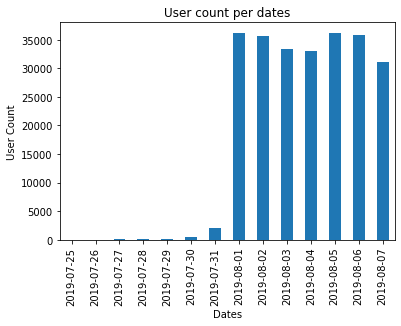

In [28]:
user_dist_hist.plot(kind="bar")
plt.title("User count per dates")
plt.xlabel("Dates")
plt.ylabel("User Count");


Сделаем срез, удалив период с небольшим количеством данных

In [29]:
cleaned_logs = full_logs.query("event_full_time > '2019-07-31'").reset_index(drop=True)

In [30]:
cleaned_logs.head()

,event_name,device_id_hash,event_time_stamp,exp_id,event_full_time,date
0,MainScreenAppear,3670880358399219515,1564535506,247,2019-07-31 01:11:46,2019-07-31
1,OffersScreenAppear,3799109751993694887,1564536064,248,2019-07-31 01:21:04,2019-07-31
2,Tutorial,1126021718529336913,1564536731,247,2019-07-31 01:32:11,2019-07-31
3,MainScreenAppear,4293428370257583636,1564539558,248,2019-07-31 02:19:18,2019-07-31
4,MainScreenAppear,4567464647598975872,1564540410,247,2019-07-31 02:33:30,2019-07-31


Для удобства зафиксируем в отдельных переменных, сколько пользователей и событий включены в очищенный лог. 

In [31]:
# Количество уникальных пользователей в очищенном логе
users_in_cleaned_logs = cleaned_logs['device_id_hash'].nunique()
# Количество событий в очищенном логе
events_in_cleaned_logs = cleaned_logs['event_name'].count()


Посмотрим, насколько удаление части данных повлияло на репрезентативность оставшейся части данных.

In [32]:

print('Доля отсеянных событий: {:.2%} ({} событий)'.format(
    (total_events - events_in_cleaned_logs) / total_events,
    total_events - events_in_cleaned_logs)
)
print('Доля отсеянных пользователей: {:.2%} ({} пользователей)'.format(
    (full_unique_users - users_in_cleaned_logs) / full_unique_users,
    full_unique_users - users_in_cleaned_logs
))

Доля отсеянных событий: 0.33% (797 событий)
Доля отсеянных пользователей: 0.12% (9 пользователей)


Посмотрим на то, как это повлияет на репрезентативность тех или иных групп пользователей, посмотрев на численнось каждой группы.

In [33]:
groups_distr = cleaned_logs.groupby('exp_id')['device_id_hash'].agg('nunique')

In [34]:
groups_distr

exp_id
246    2485
247    2517
248    2540
Name: device_id_hash, dtype: int64

Удаление 9 пользователей никак не повлияет на уровень "представленности" экспериментальных групп в совокупности. 

## Анализ воронки событий

Посмотрим подробнее на типы событий и их частоту

In [35]:
event_categories_distribution = cleaned_logs.groupby('event_name').\
agg({'event_time_stamp':'count', 'device_id_hash':'nunique'}).\
sort_values(by = 'event_time_stamp', ascending = False)
event_categories_distribution.columns = ['events_count', 'users_count']
event_categories_distribution['events_per_user'] = \
event_categories_distribution['events_count']/event_categories_distribution['users_count']

In [36]:
event_categories_distribution

,events_count,users_count,events_per_user
event_name,,,
MainScreenAppear,118681,7429,15.975367
OffersScreenAppear,46724,4606,10.144160
CartScreenAppear,42623,3742,11.390433
PaymentScreenSuccessful,34253,3542,9.670525
Tutorial,1048,845,1.240237


Чаще всего люди появляются на главной странице. Дальше резкое падение как по количеству событий, так и по количеству уникальных пользователей. При этом на одного пользователя уже приходится заметно меньшее количество событий (видимо, попав на страницу предложений и далее пользователи уже "знают", что делают). Посещение гида является в большинстве случаев явно единократным событием. 

По-видимому, этот сужающающийся по частоте ряд событий представляет собой в том числе и временную последовательность. За исключением, вероятно, обращения к страничке с руководством, которое пользователи могут выполнить на любом этапе.     

Добавим столбцы, отображающие долю пользователей, хотя раз совершивших то или иное событие,  в общем количестве, а также отношение количества пользователей на каждом этапе к количеству на предудущем этапе. 

In [37]:
event_categories_distribution['share_in_total_users'] = \
(event_categories_distribution['users_count']/users_in_cleaned_logs)*100.0


In [38]:
event_categories_distribution['share_to_previous_stage'] = \
(event_categories_distribution['users_count'].\
div(event_categories_distribution['users_count'].shift(1)))*100
event_categories_distribution = event_categories_distribution.fillna(100)

In [39]:
event_categories_distribution

,events_count,users_count,events_per_user,share_in_total_users,share_to_previous_stage
event_name,,,,,
MainScreenAppear,118681,7429,15.975367,98.501724,100.000000
OffersScreenAppear,46724,4606,10.144160,61.071334,62.000269
CartScreenAppear,42623,3742,11.390433,49.615487,81.241858
PaymentScreenSuccessful,34253,3542,9.670525,46.963670,94.655265
Tutorial,1048,845,1.240237,11.203925,23.856578


Представим воронку событий несколько более наглядно, исключив обращение к руководству, поскольку оно не является частью естественной временной последовательности. 

In [2]:

fig = go.Figure(go.Funnel(
    y = ["Переход на главную страницу", \
           "Переход на страницу предложений", \
           "Переход на страницу с корзиной", \
           "Сообщение об успешной покупке "],
    x = [7429, 4606, 3742, 3542],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )

fig.show()

NameError: name 'go' is not defined

Итак, больше всего пользователей теряется на этапе перехода от главной странице к странице предложений (38%). А вот доля людей, пожелавших совершить покупку после ознакомления с предложениями, выглядит достаточно внушительно (81%). Можно сделать предположение, что, возможно, стоит внести некие усовершенствования на главной странице, чтобы больше людей переходило с главной страницы на страницу предложений. 

In [1]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа 246',
    y = ["Переход на главную страницу", \
           "Переход на страницу предложений", \
           "Переход на страницу с корзиной", \
           "Сообщение об успешной покупке "],
    x = [2452, 1544, 1267, 1200],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Группа 247',
    orientation = "h",
    y = ["Переход на главную страницу", \
           "Переход на страницу предложений", \
           "Переход на страницу с корзиной", \
           "Сообщение об успешной покупке "],
    x = [2479, 1526, 1239, 1159],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'Группа 248',
    orientation = "h",
    y = ["Переход на главную страницу", \
           "Переход на страницу предложений", \
           "Переход на страницу с корзиной", \
           "Сообщение об успешной покупке "],
    x = [2498, 1536, 1236, 1183],
    textposition = "outside",
    textinfo = "value+percent total"))

fig.show()

NameError: name 'go' is not defined

In [42]:
print('Доля пользователей, дошедших от главной страницы до оплаты: ', (round(3542/7429, 2))*100.0, '%')

Доля пользователей, дошедших от главной страницы до оплаты:  48.0 %


**Выводы**

Итак, мы обнаружили довольно типичную воронку событий. Общая конверсия пользователей - почти 50%, что является весьма неплохим показателем. Однако стоит отметить очевидную проблему на этапе перехода от главной странице к странице предложения, на которой теряется солидная доля пользователей - почти 40%. Посмотрим, в следующем разделе, в какой степени нам может помочь изменение шрифта. 

## Анализ результатов эксперимента

### A/A тест

Как известно, для того, чтобы оценить степень подготовленности а А/В тесту сначала проводится  А/А тест. Он похож на A/B-тест, только группам показывают не разные, а одинаковые версии страниц. Именно для этого нам и нужны группы 246 и 247. 

Для начала определим, насколько различаются группы по количеству.

Посмотрим на количество пользователей в каждой группе:

In [43]:
groups_distr

exp_id
246    2485
247    2517
248    2540
Name: device_id_hash, dtype: int64

In [44]:
print ('Мы видим, что группа 246 отличается от группы 247 примерно на', \
       round (((2517/2485)*100.0 - 100), 2), '%, что в принципе является близким к допустимому отклонению в 1%')  

Мы видим, что группа 246 отличается от группы 247 примерно на 1.29 %, что в принципе является близким к допустимому отклонению в 1%


Посмотрим, есть ли "перекрестные" пользователи в различных группах. 

In [45]:
def intersection(df, column, group1, group2):
    list1 = df[df[column] == group1] [column].values.tolist()
    list2 = df[df[column] == group2] [column].values.tolist()
    return list(set(list1) & set(list2))

In [46]:
def comparison (group1, group2):
    if intersection(cleaned_logs, 'exp_id', group1, group2) == []:
        print('Нет пересечений')
    else:
        print ('Пересечения обнаружены: ', intersection(cleaned_logs, 'exp_id', group1, group2))

In [47]:
comparison (246, 247)

Нет пересечений


In [48]:
comparison (246, 248)

Нет пересечений


In [49]:
comparison (248, 247)

Нет пересечений


Пересечений между группами не обнаружено

Оценим теперь насколько статистически различаются группы 246 и 247 

Для начала произведем разбивку по событиям между группами.

In [50]:
cleaned_logs

,event_name,device_id_hash,event_time_stamp,exp_id,event_full_time,date
0,MainScreenAppear,3670880358399219515,1564535506,247,2019-07-31 01:11:46,2019-07-31
1,OffersScreenAppear,3799109751993694887,1564536064,248,2019-07-31 01:21:04,2019-07-31
2,Tutorial,1126021718529336913,1564536731,247,2019-07-31 01:32:11,2019-07-31
3,MainScreenAppear,4293428370257583636,1564539558,248,2019-07-31 02:19:18,2019-07-31
4,MainScreenAppear,4567464647598975872,1564540410,247,2019-07-31 02:33:30,2019-07-31
...,...,...,...,...,...,...
243324,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
243325,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
243326,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
243327,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [72]:
groups_by_events = cleaned_logs.pivot_table(index = 'event_name',
                                   columns = 'exp_id',
                                   values = 'device_id_hash',
                                   aggfunc = 'nunique')

In [73]:
groups_by_events

exp_id,246,247,248
event_name,,,
CartScreenAppear,1267,1239,1236
MainScreenAppear,2452,2479,2498
OffersScreenAppear,1544,1526,1536
PaymentScreenSuccessful,1200,1159,1183
Tutorial,278,285,282


In [74]:
groups_by_events = groups_by_events.sort_values (by = 246, ascending = False) 

In [75]:
groups_by_events 

exp_id,246,247,248
event_name,,,
MainScreenAppear,2452,2479,2498
OffersScreenAppear,1544,1526,1536
CartScreenAppear,1267,1239,1236
PaymentScreenSuccessful,1200,1159,1183
Tutorial,278,285,282


In [76]:
groups_distr.rename('Total', inplace = True)

exp_id
246    2485
247    2517
248    2540
Name: Total, dtype: int64

In [77]:
groups_by_events = groups_by_events.append(groups_distr)

In [78]:
groups_by_events

exp_id,246,247,248
event_name,,,
MainScreenAppear,2452,2479,2498
OffersScreenAppear,1544,1526,1536
CartScreenAppear,1267,1239,1236
PaymentScreenSuccessful,1200,1159,1183
Tutorial,278,285,282
Total,2485,2517,2540


In [79]:
groups_by_events

exp_id,246,247,248
event_name,,,
MainScreenAppear,2452,2479,2498
OffersScreenAppear,1544,1526,1536
CartScreenAppear,1267,1239,1236
PaymentScreenSuccessful,1200,1159,1183
Tutorial,278,285,282
Total,2485,2517,2540


Теперь у нас появилась основа для исследования статистических различий между всеми тремя группами. 

Группы достаточно большие. Вряд ли есть основания предполагать, что распределение отличается от нормального. Поэтому используем z-тест. Определим функцию для проведения z-теста. 

In [80]:
def z_test(a_hits, a_total, b_hits, b_total, alpha):
   
    # пропорция успехов в группе A
    p1 = a_hits / a_total
    # пропорция успехов в группе B
    p2 = b_hits / b_total
    # комбинированная пропорция успехов
    p = (a_hits + b_hits) / (a_total + b_total)
    # статистика в ст.отклонениях стандартного нормального распределения
    z_value = (p1 - p2) / np.sqrt(p * (1 - p) * (1/a_total + 1/b_total))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    # находим вероятность отклонения (z_value) от центра распределения
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    return p_value


Самое популярное событие, очевидно, попадание на главную страницу.

Определим нулевую гипотезу: между группами 246 и 247 нет статистической разницы по долям пользователей, совершивших 

In [81]:
z_test(2452,  2485,2479  , 2517, 0.05)

0.5868776836512959

Однако, вероятно, с учётом того, что по понятным причинам доля этого события во всех группах будет очень высокой (раз уж ты воспользовался приложением, то скорее всего попадешь на главную страницу), имеет смысл провести сравнить две группы и по другим событиям. 

In [90]:
def stat_compare (a_group, b_group, alpha=0.05):
    for event in groups_by_events.index:
        if event != 'Total':
            a_success = groups_by_events.loc[event, a_group]
            b_success = groups_by_events.loc[event, b_group]
            a_total = groups_by_events.loc["Total", a_group]
            b_total = groups_by_events.loc["Total", b_group]
        
            if event == 'CartScreenAppear':
                e = 'Вызов страницы с корзиной'
            if event == 'MainScreenAppear':
                e = 'Переход на главную страницу'
            if event == 'OffersScreenAppear':
                e = 'Переход на страницу с предложениями'
            if event == 'PaymentScreenSuccessful':
                e = 'Переход на страницу с предложениями' 
            if event == 'Tutorial':
                e = 'Переход на страницу с руководством'   
          
            p_value = z_test(a_success, a_total, b_success, b_total, alpha)
            if (p_value < alpha):
                print("p_value = ", round(p_value, 2), "Есть основания отвергнуть нулевую гипотезу для групп", a_group, \
                  "и", b_group, "в отношении события:", e, "Между долями есть значимая разница")
            else:
                print('p_value = {0}. Нет оснований отвергнуть нулевую гипотезу для групп: {1} и {2} в отношении события: "{3}". Нет оснований считать доли разными'.format(p_value, a_group, b_group, e ))
       

In [91]:
stat_compare (246, 247 )

p_value = 0.5868776836512959. Нет оснований отвергнуть нулевую гипотезу для групп: 246 и 247 в отношении события: "Переход на главную страницу". Нет оснований считать доли разными
p_value = 0.2743505991932964. Нет оснований отвергнуть нулевую гипотезу для групп: 246 и 247 в отношении события: "Переход на страницу с предложениями". Нет оснований считать доли разными
p_value = 0.21306131796590932. Нет оснований отвергнуть нулевую гипотезу для групп: 246 и 247 в отношении события: "Вызов страницы с корзиной". Нет оснований считать доли разными
p_value = 0.11210845100173072. Нет оснований отвергнуть нулевую гипотезу для групп: 246 и 247 в отношении события: "Переход на страницу с предложениями". Нет оснований считать доли разными
p_value = 0.8791608435102836. Нет оснований отвергнуть нулевую гипотезу для групп: 246 и 247 в отношении события: "Переход на страницу с руководством". Нет оснований считать доли разными


**Выводы**

Похоже, между группами нет статистических различий. При этом этот вывод, разумеется, сохранится при любом уровне значимости, даже равном 0.01, и тем более если мы применим поправку Бонферрони и поделим уровень значимости на коэффициент 3 по числу гипотез. 

### A/B тест

Попробуем сравнить экспериментальную группу с каждой из контрольных.

В каждом случае в качестве нулевой гипотезы примем предположение о том, что статистической разницы между группами нет.

In [ ]:
stat_compare (246, 248)

In [ ]:
stat_compare (247, 248)

Итак, ни для одного из событий нет статических различий между экспериментальной и любой из контрольных групп

Сравним экспериментальную группу с объединённой.

In [ ]:
groups_by_events['combined'] = groups_by_events[246] + groups_by_events[247]

In [ ]:
display(groups_by_events)

In [ ]:
stat_compare ('combined', 248)

Итак, и по сравнению с объединённой контрольной группой экспериментальная группа статистически не отличается.   

Как мы уже писали выше при столь высоком значении p-value для всех событий, этот вывод не изменится, разумеется, ни при более строгом уровне значимости, ни, тем более, при скорректированном на число гипотез уровне значимости. 

**Выводы по разделу**

Итак, по результатам А/А и А/В тестов можно прийти к следующим выводам:
1. Контрольные группы 246 и 247 составлены корректно. Почти одинаковые по численности, без пересечений, статистически не различающиеся
2. Не обнаружено статистически значимых различий ни между экспериментальной группой и любой из двух контрольных, ни между экспериментальной и объединённой контрольной. Этот вывод сохраняется при любых стандартно используемых уровнях значимости. В целом, это не удивительно. Вряд ли стоит ожидать, что изменение шрифта серьезно повлияет на такие показатели как общая конверсия, или воронка событий. 

## Общие выводы

1. Общая информаця о датасете:
В нашем распоряжении оказался относительно крупный датасет (244 126 строк). Пропуски не обнаружены. Небольшое количество дубликатов (удалено).
Данные приведены за две недели  дней: с 25 июля 2019 г. по 7 августа 2019 года. Однако июльские данные неполные. В связи с этим удалили данные из датафрейма, относящиеся к этому периоду. Оставили только данные с 1-го по 7-е августа. 
Имеются три группы. Две контрольные, 246 и 247 - они состоят из пользователей, которые взаимодействуют со старым интерфейсом. И одна экспериментальная, 248 - в ней пользователи, взаимодействующие с интерфейсом с изменённым шрифтом.  
Определено пять типов событий. MainScreenAppear - попадание на главную страницу OffersScreenAppear - попадание на страницу с предложениями CartScreenAppear - переход к продуктовой корзине PaymentScreenSuccessful - сообщение об успешной покупке Tutorial - гид
В среднем на одного пользователя приходится 32 события. 
2. Выводы по воронке событий
Чаще всего люди появляются на главной странице. Дальше резкое падение как по количеству событий, так и по количеству уникальных пользователей.Общая конверсия выглядит неплохо - почти половина пользователей, попавших на главную страницу, совершает покупку. Больше всего пользователей теряется на этапе перехода от главной странице к странице предложений (38%). А вот доля людей, пожелавших совершить покупку после ознакомления с предложениями, выглядит достаточно внушительно (81%). Можно сделать предположение, что, возможно, стоит внести некие усовершенствования на главной странице, чтобы больше людей переходило с главной страницы на страницу предложений.
3. Выводы по тестам А/A/B 
Контрольные группы 246 и 247 составлены корректно. Не обнаружено статистически значимых различий ни между экспериментальной группой и любой из двух контрольных, ни между экспериментальной и объединённой контрольной. Этот вывод сохраняется при любых стандартно используемых уровнях значимости. 

<hr style="border: 2px solid green;" />

## Общий комментарий
Спасибо за проделанную работу🤝

Денис, работа выполнена прекрасно, ты отлично разобрался с данными по АВ тесту, молодец💪

Есть только одна доработка:
- детальнее изучить кол-во событий на пользователя

Согласен с общим выводом: изменением шрифта не влияет на конверсия в различные этапы, поэтому его можно внедрять, если он по каким-либо другим причинам подходит больше.

Исправляй и отправляй на проверку🛠